In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-predictions-dataset/train.csv
/kaggle/input/weather-predictions-dataset/test.csv


# **1. Imports & Setup**

This first section will cover the necessary imports and setup for your project.

In [2]:
# Imports for Data Manipulation
import numpy as np
import pandas as pd

# Imports for Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Imports for Exploratory Data Analysis (EDA)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# TensorFlow and Keras imports
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout


# For evaluation
from sklearn.metrics import accuracy_score

# **2. Loading Data**

This part will load the training and testing data, and handle basic cleaning steps like dropping missing values.

In [3]:
# Load data
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # Drop rows with missing values
    train.dropna(inplace=True)
    test.dropna(inplace=True)
    
    return train, test

# Set your file paths
train_path = '/kaggle/input/weather-predictions-dataset/train.csv'
test_path = '/kaggle/input/weather-predictions-dataset/test.csv'

train, test = load_data(train_path, test_path)

# Show first few rows of data to confirm it's loaded properly
print("Training Dataset: \n")
print(train.head())
print("\n\n\nTesting Dataset: \n")
print(test.head())

Training Dataset: 

                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Cloud Cover  Pressure (millibars)  \
0                     251          15.8263            0  

In [4]:
# Show datatypes for the data
print("Training Data Types: \n")
print(train.dtypes)

Training Data Types: 

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)        int64
Visibility (km)             float64
Cloud Cover                   int64
Pressure (millibars)        float64
Daily Summary                object
dtype: object


# **3. Exploratory Data Analysis (EDA)**
   
This section includes the exploratory analysis, including the distribution of numerical features, categorical feature counts, and correlations.

In [5]:
# Check for null values in the data
train.isnull().sum(), test.isnull().sum()

(Formatted Date              0
 Summary                     0
 Precip Type                 0
 Temperature (C)             0
 Apparent Temperature (C)    0
 Humidity                    0
 Wind Speed (km/h)           0
 Wind Bearing (degrees)      0
 Visibility (km)             0
 Cloud Cover                 0
 Pressure (millibars)        0
 Daily Summary               0
 dtype: int64,
 Formatted Date              0
 Summary                     0
 Precip Type                 0
 Temperature (C)             0
 Apparent Temperature (C)    0
 Humidity                    0
 Wind Speed (km/h)           0
 Wind Bearing (degrees)      0
 Visibility (km)             0
 Cloud Cover                 0
 Pressure (millibars)        0
 Daily Summary               0
 dtype: int64)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


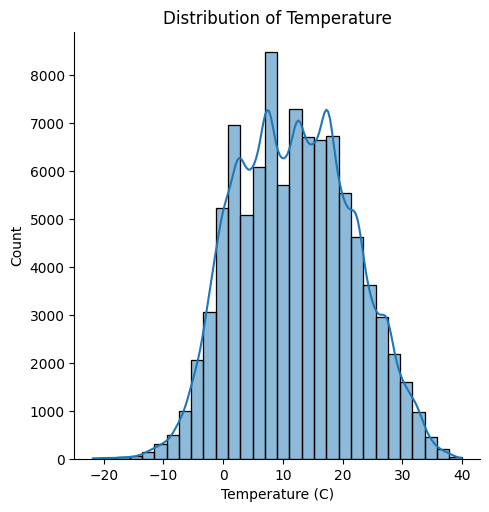

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


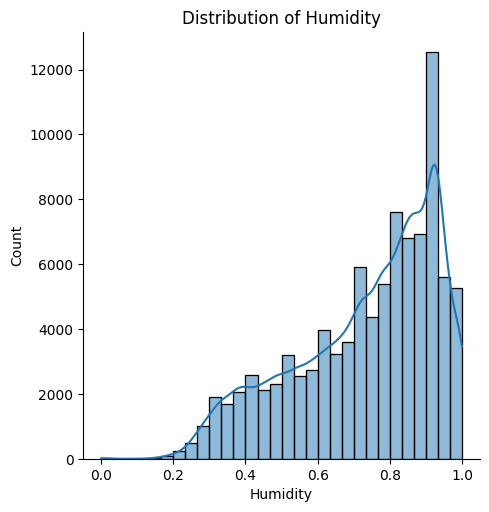

In [6]:
# EDA on numerical features
sns.displot(train['Temperature (C)'], kde=True, bins=30)
plt.title('Distribution of Temperature')
plt.show()

sns.displot(train['Humidity'], kde=True, bins=30)
plt.title('Distribution of Humidity')
plt.show()

# # EDA on categorical features
# sns.countplot(train['Summary'])
# plt.title('Weather Summary Distribution')
# plt.xticks(rotation=90)
# plt.show()

# sns.countplot(train['Precip Type'])
# plt.title('Precipitation Type Distribution')
# plt.show()

# **4. Feature Engineering**
   
Here, we add cyclical features for the month and create sequences for the LSTM model.

In [7]:
# Convert 'Formatted Date' column to datetime, handling errors
train['Formatted Date'] = pd.to_datetime(train['Formatted Date'], errors='coerce', utc=True).dt.tz_localize(None)
test['Formatted Date'] = pd.to_datetime(test['Formatted Date'], errors='coerce', utc=True).dt.tz_localize(None)


In [8]:
# Add cyclic features for seasonality (month)
def add_cyclic_features(data, date_column):
    data['month_sin'] = np.sin(2 * np.pi * data[date_column].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data[date_column].dt.month / 12)
    return data


# Add cyclic features for both train and test data
train = add_cyclic_features(train, 'Formatted Date')
test = add_cyclic_features(test, 'Formatted Date')

# Show the new features added
train.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),Daily Summary,month_sin,month_cos
0,2006-03-31 22:00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.,1.000000,6.123234e-17
1,2006-03-31 23:00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.,1.000000,6.123234e-17
2,2006-04-01 00:00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.,0.866025,-5.000000e-01
3,2006-04-01 01:00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.,0.866025,-5.000000e-01
4,2006-04-01 02:00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.,0.866025,-5.000000e-01


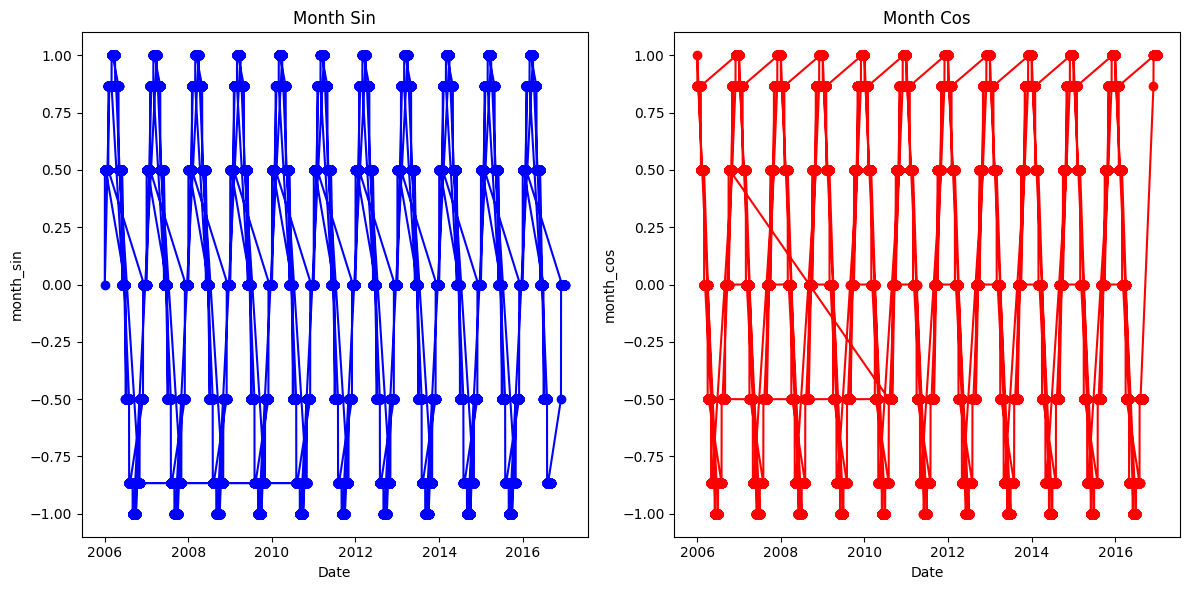

In [9]:
# Now proceed with plotting
plt.figure(figsize=(12, 6))

# Plot month_sin
plt.subplot(1, 2, 1)
plt.plot(train['Formatted Date'], train['month_sin'], marker='o', linestyle='-', color='b')
plt.title('Month Sin')
plt.xlabel('Date')
plt.ylabel('month_sin')

# Plot month_cos
plt.subplot(1, 2, 2)
plt.plot(train['Formatted Date'], train['month_cos'], marker='o', linestyle='-', color='r')
plt.title('Month Cos')
plt.xlabel('Date')
plt.ylabel('month_cos')

plt.tight_layout()
plt.show()


# **5. Data Preprocessing and Encoding**

Encode categorical variables like Summary and Precip Type using LabelEncoder, and scale features with MinMaxScaler.

In [10]:
train.dtypes

Formatted Date              datetime64[ns]
Summary                             object
Precip Type                         object
Temperature (C)                    float64
Apparent Temperature (C)           float64
Humidity                           float64
Wind Speed (km/h)                  float64
Wind Bearing (degrees)               int64
Visibility (km)                    float64
Cloud Cover                          int64
Pressure (millibars)               float64
Daily Summary                       object
month_sin                          float64
month_cos                          float64
dtype: object

In [11]:
test.dtypes

Formatted Date              datetime64[ns]
Summary                             object
Precip Type                         object
Temperature (C)                    float64
Apparent Temperature (C)           float64
Humidity                           float64
Wind Speed (km/h)                  float64
Wind Bearing (degrees)               int64
Visibility (km)                    float64
Cloud Cover                          int64
Pressure (millibars)               float64
Daily Summary                       object
month_sin                          float64
month_cos                          float64
dtype: object

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Encoding categorical variables
def encode_categorical(train, test):
    le_summary = LabelEncoder()
    le_precip = LabelEncoder()

    # Fit LabelEncoder on combined data to avoid unseen labels
    le_summary.fit(pd.concat([train['Summary'], test['Summary']], axis=0))
    le_precip.fit(pd.concat([train['Precip Type'], test['Precip Type']], axis=0))

    # Encode 'Summary' and 'Precip Type' in both train and test
    train['Summary'] = le_summary.transform(train['Summary'])
    test['Summary'] = le_summary.transform(test['Summary'])

    train['Precip Type'] = le_precip.transform(train['Precip Type'])
    test['Precip Type'] = le_precip.transform(test['Precip Type'])

    return train, test, le_summary, le_precip

# Apply the encoding function
train, test, le_summary, le_precip = encode_categorical(train, test)

# Drop columns that are not needed for modeling
X_train = train.drop(columns=['Formatted Date', 'Daily Summary'])
y_train = train['Daily Summary']
X_test = test.drop(columns=['Formatted Date', 'Daily Summary'])
y_test = test['Daily Summary']

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **6. Create Sequences for LSTM**
   
Since you will use an LSTM model, you need to reshape your data into sequences.

In [13]:
# Function to create sequences for LSTM
def create_sequences(data, sequence_length=7):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i + sequence_length])  # Predict the next day's summary
    return np.array(sequences), np.array(targets)

# Create sequences from the scaled data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, sequence_length=7)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, sequence_length=7)

# Check the shape of the sequences
X_train_seq.shape, y_train_seq.shape

((94118, 7, 12), (94118, 12))

In [14]:
print(len(X_train_seq[0]))
print(len(y_train_seq[0]))
print(len(X_test_seq[0]))
print(len(y_test_seq[0]))

7
12
7
12


In [20]:
print(y_train_seq[0][4])

0.89


# **7. Model Building**
   
In this section, build and compile the LSTM model.

In [21]:
# Ensure GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Define the function to create the model
def build_gru_model(hp):
    model = Sequential()
    # Add GRU layer with variable units
    model.add(GRU(
        units=hp.Int('units', min_value=32, max_value=256, step=32), 
        activation='relu', 
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ))
    # Add Dropout for regularization
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    # Dense layer
    model.add(Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'))
    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_gru_model,
    objective='val_mae',
    max_epochs=50,
    factor=3,
    directory='hyperband_logs',
    project_name='gru_weather_forecasting'
)

# Define the callback to stop early if no improvement is observed
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train_seq, y_train_seq, validation_split=0.2, epochs=50, callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best number of GRU units: {best_hps.get('units')}
Best dropout rate: {best_hps.get('dropout_rate')}
Best number of dense units: {best_hps.get('dense_units')}
Best learning rate: {best_hps.get('learning_rate')}
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[stop_early]
)

Trial 90 Complete [00h 01m 00s]
val_mae: 0.3097391128540039

Best val_mae So Far: 0.30809634923934937
Total elapsed time: 01h 03m 14s

Best number of GRU units: 160
Best dropout rate: 0.2
Best number of dense units: 16
Best learning rate: 0.001

Epoch 1/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.1218 - mae: 0.3073 - val_loss: 0.1234 - val_mae: 0.3084
Epoch 2/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1196 - mae: 0.3056 - val_loss: 0.1233 - val_mae: 0.3083
Epoch 3/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1194 - mae: 0.3053 - val_loss: 0.1233 - val_mae: 0.3085
Epoch 4/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1194 - mae: 0.3052 - val_loss: 0.1233 - val_mae: 0.3089
Epoch 5/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1195 - mae: 0.3054 - val_loss: 0.1235 - val_mae: 0.3095
Epoch 6/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1195 - mae: 0.3054 - val_loss: 0.1233 - val_mae: 0.3086
Epoch 7/50
4706/4706 ━━━━━━━

In [41]:
# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(X_test_seq, y_test_seq)
print(f"Test MAE: {test_mae}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1112 - mae: 0.2833
Test MAE: 0.3009799122810364


# **8. Evaluate the Model**
   
Finally, after training the model, evaluate its performance.

In [42]:
# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(X_test_seq, y_test_seq)
print(f"Test MAE: {test_mae}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1112 - mae: 0.2833
Test MAE: 0.3009799122810364


# **9. Saving the Model**
   
Finally, after evaluating the model, save the model.

In [44]:
# Save the model for future use
best_model.save("/kaggle/working/model/gru_model_weather_forecasting.h5")